In [5]:
import os
os.chdir("C:/Users/Xtage/OneDrive - Xtage Technologies Private Limited/UTec - Map Detection")
import config
import cv2
import numpy as np
from matplotlib import pyplot as plt 

from Auto.Library_Directory import create_stremlit_folder, create_folder
from Auto.Library_Image import read_image, detect_edges, detect_lines, create_blank_image
from Auto.Library_Streamlit import save_uploaded_image, display_images_in_directory
import config

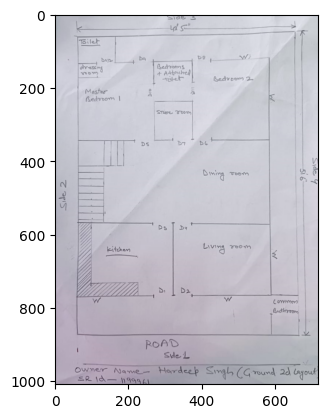

In [10]:
# Processing image
# Step 01: Reading Image
image_raw = read_image(dir_ip=config.dir_prj_ip, image_name=config.prj_id + ".png")
# display_images_in_directory(folder_path, image_name="Raw.png")
plt.imshow(image_raw)

In [17]:
config.dir_prj_ip + "/" + config.prj_id + ".png"

'C:/Users/Xtage/OneDrive - Xtage Technologies Private Limited/UTec - Map Detection/Input/006_Sample_Maps/006_Sample_Maps.png'

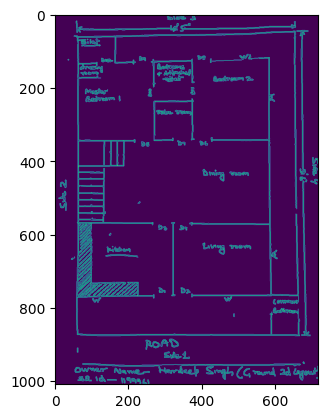

In [18]:
# Step 02: Detecting Edges
image_edges = detect_edges(image=image_raw, dir_op=config.dir_prj_op_edges)
plt.imshow(image_edges)

In [23]:
def detect_lines(image_edges = None, image_raw = None, dir_ip=None, dir_op=None, line_color=(0, 165, 255), is_on_blank=False):
    if image_edges is None:
        return "image not found"
    minLineLength=100
    # best:minLineLength=100, threshold=100, maxLineGap=80
    lines = cv2.HoughLinesP(image=image_edges,
                            rho=1,
                            theta=np.pi/180, 
                            threshold=100, 
                            lines=np.array([]), 
                            minLineLength=minLineLength,
                            maxLineGap=80)
    a,b,c = lines.shape

    if is_on_blank==False:
        for i in range(a):
            cv2.line(image_raw, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), line_color, 1, cv2.LINE_AA)
        cv2.imwrite(dir_op + "/" + "Lines.png", image_raw)
    elif is_on_blank==True:
        image_raw = create_blank_image(image=image_raw)    
        for i in range(a):
            cv2.line(image_raw, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), line_color, 1, cv2.LINE_AA)
        
        cv2.imwrite(dir_op + "/" + "Lines2.png", image_raw)

    return lines, image_raw

In [ ]:
# Step 03: Detecting Lines
lines, image_map = detect_lines(image_edges=image_edges, image_raw=image_raw, dir_op=config.dir_prj_op_hough, line_color=(0, 165, 255), is_on_blank=False)
# plt.imshow(image_map)

In [178]:
def get_horizontal_lines(lines, threshold, verbose=False):
    horizontal_lines = []
    # Iterate through each line
    for line in lines:
        x1, y1, x2, y2 = line[0]  # Extract line coordinates

        # Check if the line is approximately horizontal
        if abs(y2 - y1) < threshold:
            horizontal_lines.append(line)

    if verbose:
        print("horizontal_lines")
        print(horizontal_lines)
    horizontal_lines = [np.array([[min(x[0][0], x[0][2]), x[0][1], max(x[0][0], x[0][2]), x[0][3]]]) for x in horizontal_lines]
    
    return horizontal_lines

def get_vertical_lines(lines, threshold, verbose=False):
    vertical_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]  # Extract line coordinates
        # Check if the line is approximately vertical
        if abs(x2 - x1) < threshold:
            vertical_lines.append(line)

    if verbose:
        print("vertical_lines")
        print(vertical_lines)


    vertical_lines = [np.array([[x[0][0], min(x[0][1], x[0][3]), x[0][2], max(x[0][1], x[0][3])]]) for x in vertical_lines]    

    return vertical_lines

In [35]:
def plot_lines(image=None, lines=None):
    if image is None:
        return "image not found"
    blank_image = create_blank_image(image)

    for index, line in enumerate(lines):
        # print(line)
        cv2.line(blank_image, (line[0], line[1]), (line[2], line[3]), (0, 0, 0), 1, cv2.LINE_AA)

    return blank_image    


horizontal_lines
[array([[357, 876, 684, 876]], dtype=int32), array([[ 54,  61, 241,  58]], dtype=int32), array([[204, 873, 540, 873]], dtype=int32), array([[ 58, 768, 679, 768]], dtype=int32), array([[ 58, 766, 682, 766]], dtype=int32), array([[324, 955, 667, 955]], dtype=int32), array([[ 66, 344, 321, 344]], dtype=int32), array([[ 84, 571, 657, 571]], dtype=int32), array([[ 59,  63, 534,  55]], dtype=int32), array([[344, 958, 653, 958]], dtype=int32), array([[118, 957, 455, 957]], dtype=int32), array([[ 60, 874, 203, 874]], dtype=int32), array([[ 59,  40, 316,  40]], dtype=int32), array([[215, 342, 672, 342]], dtype=int32), array([[222, 875, 427, 875]], dtype=int32), array([[148, 568, 548, 574]], dtype=int32), array([[556,  50, 688,  45]], dtype=int32), array([[ 65, 346, 218, 346]], dtype=int32), array([[283, 970, 707, 978]], dtype=int32), array([[ 59,  41, 444,  41]], dtype=int32), array([[ 62, 134, 485, 126]], dtype=int32), array([[284, 969, 707, 976]], dtype=int32), array([[209,  

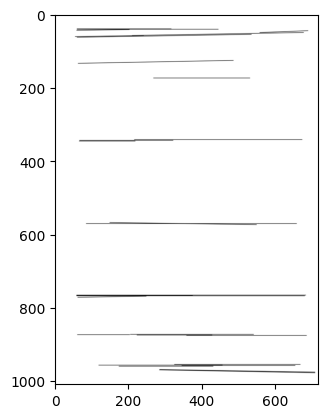

In [179]:
horizontal_lines = get_horizontal_lines(lines.copy(), threshold=10, verbose=True)
horizontal_lines = [x[0] for x in horizontal_lines]
image_horizontal_lines = plot_lines(image = image_map, lines = horizontal_lines)
plt.imshow(image_horizontal_lines)

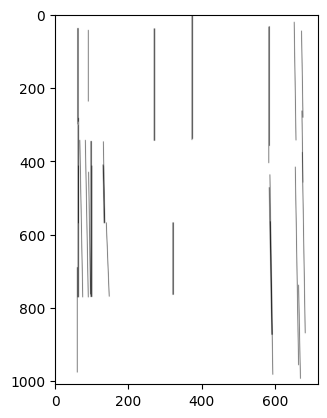

In [181]:
vertical_lines = get_vertical_lines(lines.copy(), threshold=10)
vertical_lines = [x[0] for x in vertical_lines]
image_vertical_lines = plot_lines(image = image_map, lines = vertical_lines)
plt.imshow(image_vertical_lines)

In [201]:
def group_horizontal_lines(lines=None, threshold=10, verbose=False):
    horizontal_lines = sorted(lines, key=lambda line: line[1])  # Sort lines based on x coordinates
    grouped_lines_horizontal = []

    if horizontal_lines:
        current_group = [horizontal_lines[0]]
        if verbose:
            print("step 01: cg", current_group)

        for i in range(1, len(horizontal_lines)):
            # Check the difference between y coordinates
            if abs(horizontal_lines[i][1] - horizontal_lines[i-1][1]) < threshold:
                current_group.append(horizontal_lines[i])
                if verbose:
                    print("step 02: ag", horizontal_lines[i])
            else:
                grouped_lines_horizontal.append(current_group)
                current_group = [horizontal_lines[i]]

        grouped_lines_horizontal.append(current_group)
        
    grouped_lines_horizontal_max = []
    for index, grp in enumerate(grouped_lines_horizontal):
        grouped_lines_horizontal_max.append([np.array([min([x[0] for x in grp]), grp[0][1], max([x[2] for x in grp]), grp[0][3]], dtype=np.int32)][0])

    horizontal_lines_first_adjusted = [np.array([x[0], x[1], x[2], x[1]], dtype=np.int32) for x in grouped_lines_horizontal_max]
    
    return grouped_lines_horizontal, grouped_lines_horizontal_max, horizontal_lines_first_adjusted

In [182]:
def group_vertical_lines(lines=None, threshold=10, verbose=False):
    vertical_lines = sorted(lines, key=lambda line: line[0])  # Sort lines based on y coordinates
    grouped_lines_vertical = []

    if vertical_lines:
        current_group = [vertical_lines[0]]

        for i in range(1, len(vertical_lines)):
            # Check the difference between y coordinates
            if (abs(vertical_lines[i][0] - vertical_lines[i-1][0])) < threshold:
                current_group.append(vertical_lines[i])
                # print("detected")
            else:
                grouped_lines_vertical.append(current_group)
                current_group = [vertical_lines[i]]

        grouped_lines_vertical.append(current_group)

    grouped_lines_vertical_max = []
    for index, grp in enumerate(grouped_lines_vertical):
        grouped_lines_vertical_max.append([np.array([grp[0][0], min(x[1] for x in grp), grp[0][2], max([x[3] for x in grp])], dtype=np.int32)][0])

    vertical_lines_first_adjusted = [np.array([x[0], x[1], x[0], x[3]], dtype=np.int32) for x in grouped_lines_vertical_max]

    return grouped_lines_vertical, grouped_lines_vertical_max, vertical_lines_first_adjusted

In [222]:
def correct_image(lines=None, image=None, dir_ip=None, dir_op=None, verbose=False):

    horizontal_lines = get_horizontal_lines(lines.copy(), threshold=10, verbose=False)
    horizontal_lines = [x[0] for x in horizontal_lines]
    image_horizontal_lines = plot_lines(image = image_map, lines = horizontal_lines)
    if verbose:
        plt.imshow(image_horizontal_lines)
    
    vertical_lines = get_vertical_lines(lines.copy(), threshold=10)
    vertical_lines = [x[0] for x in vertical_lines]
    image_vertical_lines = plot_lines(image = image_map, lines = vertical_lines)
    if verbose:
        plt.imshow(image_vertical_lines)

    grouped_lines_horizontal, grouped_lines_horizontal_max, horizontal_lines_first_adjusted = \
    group_horizontal_lines(lines=horizontal_lines, threshold=10)
    image_horizontal_lines_grouped = plot_lines(image=image_map, lines=horizontal_lines_first_adjusted)
    # plt.imshow(image_horizontal_lines_grouped)

    grouped_lines_vertical, grouped_lines_vertical_max, vertical_lines_first_adjusted = \
        group_vertical_lines(lines=vertical_lines, threshold=20)
    image_vertical_lines_grouped = plot_lines(image=image_map, lines=vertical_lines_first_adjusted)
    # plt.imshow(image_vertical_lines_grouped)

    consolidated_lines = horizontal_lines_first_adjusted.copy()
    consolidated_lines.extend(vertical_lines_first_adjusted)
    image_lines_grouped = plot_lines(image = image_map, lines = consolidated_lines)
    if verbose:
        plt.imshow(image_lines_grouped)

    cv2.imwrite(dir_op + "/" + "Corrected.png", image_lines_grouped)

    return image_lines_grouped

In [206]:
grouped_lines_horizontal, grouped_lines_horizontal_max, horizontal_lines_first_adjusted = \
    group_horizontal_lines(lines=horizontal_lines, threshold=10)
image_horizontal_lines_grouped = plot_lines(image=image_map, lines=horizontal_lines_first_adjusted)
# plt.imshow(image_horizontal_lines_grouped)

In [209]:
grouped_lines_vertical, grouped_lines_vertical_max, vertical_lines_first_adjusted = \
    group_vertical_lines(lines=vertical_lines, threshold=20)
image_vertical_lines_grouped = plot_lines(image=image_map, lines=vertical_lines_first_adjusted)
# plt.imshow(image_vertical_lines_grouped)

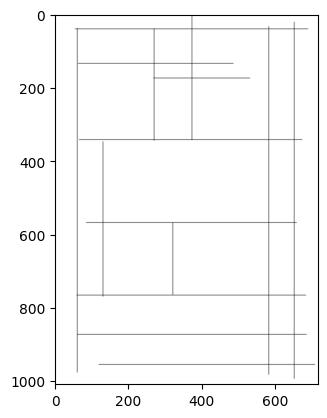

In [210]:
consolidated_lines = horizontal_lines_first_adjusted.copy()
consolidated_lines.extend(vertical_lines_first_adjusted)
image_lines_grouped = plot_lines(image = image_map, lines = consolidated_lines)
plt.imshow(image_lines_grouped)

End of file

In [225]:
import cv2
import numpy as np

def extract_rectangles(image_path):
    # Read the image
    img = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply GaussianBlur to reduce noise and help with contour detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Canny edge detector to find edges in the image
    edges = cv2.Canny(blurred, 50, 150)
    
    # Find contours in the edged image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Iterate over the contours
    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Check if the polygon has four vertices, indicating a rectangle
        if len(approx) == 4:
            # Draw the rectangle around the detected shape
            cv2.drawContours(img, [approx], 0, (0, 255, 0), 2)
    
    return img



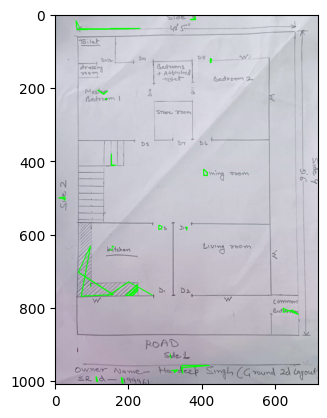

In [227]:
# Example usage
image_path = config.dir_prj_ip + "/" + config.prj_id + ".png"
plt.imshow(extract_rectangles(image_path))


In [253]:
import cv2
import numpy as np

img = cv2.imread(image_path)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)

kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(gray,kernel,iterations = 2)
kernel = np.ones((4,4),np.uint8)
dilation = cv2.dilate(erosion,kernel,iterations = 2)

edged = cv2.Canny(dilation, 30, 200)

contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

rects = [cv2.boundingRect(cnt) for cnt in contours]
rects = sorted(rects,key=lambda  x:x[1],reverse=True)




In [261]:
rects

[(208, 1003, 11, 6),
 (220, 999, 12, 10),
 (190, 997, 17, 12),
 (180, 991, 78, 18),
 (712, 989, 6, 7),
 (76, 988, 9, 6),
 (62, 987, 40, 16),
 (62, 987, 40, 16),
 (111, 985, 58, 20),
 (111, 985, 58, 20),
 (194, 977, 8, 4),
 (240, 974, 20, 7),
 (326, 970, 11, 7),
 (512, 966, 21, 26),
 (512, 966, 21, 26),
 (538, 965, 64, 25),
 (161, 965, 81, 20),
 (54, 963, 91, 17),
 (433, 962, 54, 37),
 (282, 961, 47, 21),
 (411, 960, 49, 36),
 (282, 960, 111, 30),
 (335, 960, 58, 30),
 (54, 953, 664, 48),
 (76, 953, 12, 6),
 (297, 921, 54, 20),
 (297, 921, 19, 18),
 (348, 920, 20, 22),
 (348, 920, 20, 22),
 (60, 910, 5, 14),
 (60, 910, 5, 14),
 (321, 896, 15, 9),
 (321, 896, 10, 9),
 (247, 886, 91, 31),
 (662, 832, 6, 10),
 (584, 816, 10, 6),
 (593, 801, 72, 18),
 (593, 778, 69, 16),
 (593, 778, 69, 16),
 (106, 773, 21, 17),
 (267, 765, 5, 12),
 (371, 763, 6, 11),
 (343, 746, 27, 18),
 (343, 746, 27, 18),
 (282, 746, 20, 16),
 (282, 746, 20, 16),
 (433, 634, 11, 6),
 (138, 633, 90, 34),
 (138, 633, 90, 

In [269]:
i = -1
j = 1
y_old = 0
x_old = 0
index = 1
for rect in rects:
    x,y,w,h = rect
    area = w * h

    if area > 0:

        if (y_old - y) > 200:
            i += 1
            y_old = y

        if abs(x_old - x) > 300:
            x_old = x
            x,y,w,h = rect

            out = img[y+10:y+h-10,x+10:x+w-10]
            print(out)
            if len(out) != 0:
                cv2.imwrite(config.dir_prj_op + "/" + str(index) + ".png", out)
                index = index + 1

            j+=1

[]
[]
[[[172 174 182]]

 [[163 165 173]]

 [[160 162 170]]

 [[170 172 180]]

 [[172 174 182]]

 [[169 171 179]]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [268]:
len(out)

0

In [249]:
img = cv2.imread(image_path, 0)
h, w = img.shape[:2]
kernel = np.ones((15,15),np.uint8)

e = cv2.erode(img,kernel,iterations = 2)  
d = cv2.dilate(e,kernel,iterations = 1)
ret, th = cv2.threshold(d, 150, 255, cv2.THRESH_BINARY_INV)

mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(th, mask, (200,200), 255); # position = (200,200)
out = cv2.bitwise_not(th)
out= cv2.dilate(out,kernel,iterations = 3)
cnt, h = cv2.findContours(out,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [232]:
import time

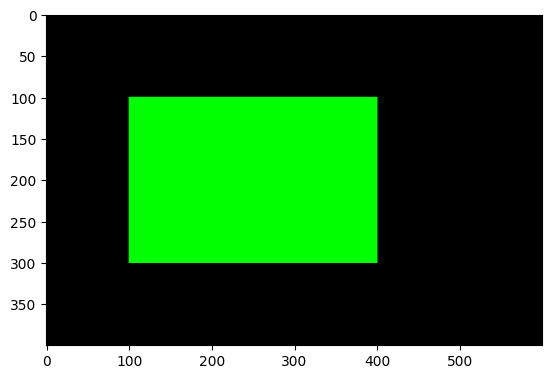

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Create a black image (all zeros)
image = np.zeros((400, 600, 3), dtype=np.uint8)

# Define rectangle parameters
top_left = (100, 100)
bottom_right = (400, 300)
color = (0, 255, 0)  # RGB color format (here, green)

# Draw and fill the rectangle on the image
cv2.rectangle(image, top_left, bottom_right, color, thickness=cv2.FILLED)

plt.imshow(image)

0
1
2
3


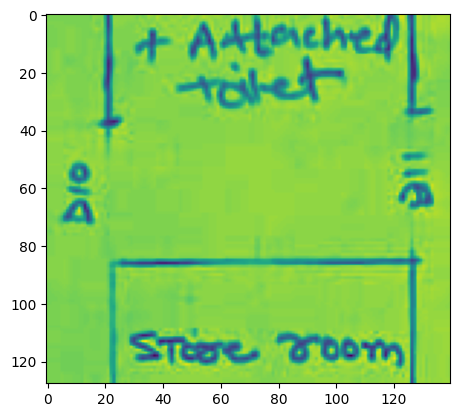

In [248]:
for i in range(len(cnt)):
    area = cv2.contourArea(cnt[i])
    print(i)
    if(area>0):
        mask = np.zeros_like(img)
        cv2.drawContours(mask, cnt, i, 255, -1)
        x,y,w,h = cv2.boundingRect(cnt[i])
        crop= img[ y:h+y,x:w+x]
        plt.imshow(crop)
        if i == 3:
            break


In [244]:
cv2.imshow("dfd", image_map)

In [ ]:
gray = cv2.imread(config.dir_prj_ip + "/" + config.prj_id + ".png")
edges = cv2.Canny(gray,50,150,apertureSize = 3)
cv2.imwrite(config.dir_prj_op_edges + "/" + "Edges.png",edges)
minLineLength=100 * 1
lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=minLineLength,maxLineGap=90)
# Assume 'lines' is obtained using cv2.HoughLinesP

# Create lists to store horizontal and vertical lines
horizontal_lines = []
vertical_lines = []

# Define thresholds for grouping lines
y_threshold = 10  # Adjust according to your requirements for horizontal lines
x_threshold = 10  # Adjust according to your requirements for vertical lines

# Iterate through each line
for line in lines:
    x1, y1, x2, y2 = line[0]  # Extract line coordinates

    # Check if the line is approximately horizontal
    if abs(y2 - y1) < y_threshold:
        horizontal_lines.append(line)
    # Check if the line is approximately vertical
    elif abs(x2 - x1) < x_threshold:
        vertical_lines.append(line)

# Function to group lines based on the specified threshold
def group_lines_horizontal(lines, threshold):
    lines = sorted(lines, key=lambda line: line[0][0])  # Sort lines based on x coordinates
    grouped_lines = []

    if lines:
        current_group = lines[0]

        for i in range(1, len(lines)):
            # Check the difference between y coordinates
            if abs(lines[i][0][1] - lines[i-1][0][1]) < threshold:
                # current_group.append(lines[i])
                print("detected")
            else:
                grouped_lines.append(current_group)
                current_group = lines[i]

        grouped_lines.append(current_group)

    return grouped_lines


def group_lines_vertical(lines, threshold):
    lines = sorted(lines, key=lambda line: line[0][1])  # Sort lines based on y coordinates
    grouped_lines = []

    if lines:
        current_group = lines[0]

        for i in range(1, len(lines)):
            # Check the difference between y coordinates
            if abs(lines[i][0][1] - lines[i-1][0][1]) < threshold:
                # current_group.append(lines[i])
                print("detected")
            else:
                grouped_lines.append(current_group)
                current_group = lines[i]

        grouped_lines.append(current_group)

    return grouped_lines


# Group horizontal lines
grouped_horizontal_lines = group_lines_horizontal(horizontal_lines, y_threshold)

# Group vertical lines
grouped_vertical_lines = group_lines_vertical(vertical_lines, x_threshold)

# Now 'grouped_horizontal_lines' and 'grouped_vertical_lines' contain lists of lines grouped based on the specified thresholds
